<a href="https://colab.research.google.com/github/Hernan1787/Proyecto_Etapa_1/blob/main/Proyecto_I_Etapa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto I Etapa

# Dependencias

In [ ]:
!pip install face_recognition         # Install face_recognition package using pip
import face_recognition
import cv2                           # Import OpenCV
import numpy as np
import pickle
from matplotlib import pyplot as plt  # pyplot

from google.colab import drive
drive.mount('/content/drive')

# ipywidgets packages
import ipywidgets as widgets
from IPython.display import display, clear_output

# Live Streaming dependencies
from IPython.display import Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time
!pip install pytz
import datetime
import pytz
local_tz = pytz.timezone('America/Costa_Rica')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566171 sha256=4a7f23ce771f86b847e979c645a3e1760120135e74eea0b771f9dca33c6de21d
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models
Mounted at /content/drive


# Utilidades

## Listas globales

In [ ]:
#Rostros registrados
registered_faces = {}

#Listas principales
lista_profesores = [] #Lista master de profesores
lista_estudiantes = [] #Lista master de Estudiantes
lista_miselaneos = [] #Lista master de miselaneos
lista_aulas = [] #Lista master de aulas
lista_cursos = [] #Lista master de cursos

lista_estudiantes_cursos = [] #Lista master de estudiantes matriculados

lista_pres = [] #Lista temporal de asistencia
lista_consulta_6 = [] #Lista master de informacion consulta 6
lista_consulta_9 = [] #Lista master de informacion consulta 9
lista_imagenes = []





# Base de datos

In [ ]:
def cargar_base_de_datos():
   with open("/content/drive/MyDrive/Base_de_datos_taller/rostros.bin", "rb") as tf:
    global registered_faces
    registered_faces = pickle.load(tf)
   with open("/content/drive/MyDrive/Base_de_datos_taller/profesores.bin", "rb") as p:
    global lista_profesores
    lista_profesores = pickle.load(p)
   with open("/content/drive/MyDrive/Base_de_datos_taller/estudiantes.bin", "rb") as e:
    global lista_estudiantes
    lista_estudiantes = pickle.load(e)
   with open("/content/drive/MyDrive/Base_de_datos_taller/miselaneos.bin", "rb") as m:
    global lista_miselaneos
    lista_miselaneos = pickle.load(m)
   with open("/content/drive/MyDrive/Base_de_datos_taller/aulas.bin", "rb") as a:
    global lista_aulas
    lista_aulas = pickle.load(a)
   with open("/content/drive/MyDrive/Base_de_datos_taller/cursos.bin", "rb") as c:
    global lista_cursos
    lista_cursos = pickle.load(c)
   with open("/content/drive/MyDrive/Base_de_datos_taller/est_cur.bin", "rb") as ec:
    global lista_estudiantes_cursos
    lista_estudiantes_cursos = pickle.load(ec)
   with open("/content/drive/MyDrive/Base_de_datos_taller/precentes.bin", "rb") as pr:
    global lista_consulta_9
    lista_consulta_9 = pickle.load(pr)

cargar_base_de_datos()


## Streaming en vivo

In [ ]:
def check_if_face_registered(face_encoding):
  for _, registered_face in registered_faces.items():
    if True in face_recognition.compare_faces([face_encoding], registered_face):
      return True
  return False

## face recognition

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 800, 600);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 800; //video.videoWidth;
      captureCanvas.height = 600; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

In [ ]:
# JavaScript code to stop the webcam stream
js_stop_stream = """
    const stream = video.srcObject;
    const tracks = stream.getTracks();

    tracks.forEach(function(track) {
        track.stop();
    });

    video.srcObject = null;
    div.style.display = 'none';  // Hide the container
"""

# Function to stop the video streaming
def stop_video_stream():
    display(Javascript(js_stop_stream))

# Registro de Profesores

In [ ]:
dic_profesores = {}
dic_tel_prof = {}
lista_email_prof = []
cedula = input("Digite el numero de cedula: ")
dic_profesores["cedula"] = cedula

nacimiento = input("Digite la fecha de nacimiento: ")
dic_profesores["nacimiento"] = nacimiento

edad = int(input("Digite la edad del profesor: "))
dic_profesores["edad"] = edad

sexo = input("Genero : ")
dic_profesores["sexo"] = sexo

nacionalidad = input("Digite la nacionalidad: ")
dic_profesores["nacionalidad"] = nacionalidad

cant = int(input("Digite la cantidad de numeros de telefono que quiere agregar: "))
cont = 0
while cont < cant:
  telefono = input("Digite el numero de telefono ")
  dic_tel_prof["tel"+str(cont)] = telefono
  cont+=1
dic_profesores["telefonos"] = dic_tel_prof

while True:
  email = input("Digite el email: ")
  lista_email_prof.append(email)
  otr = input("Si desea agregar otro email digite 'si', si no digite 'no'")
  if otr != "si":
    break
dic_profesores["email"] = lista_email_prof

direccion = input("Digite lugar de residencia: ")
dic_profesores["direccion"] = direccion

especialidad = input("Especialidad del profesor: ")
dic_profesores["especialidad"] = especialidad

# Create a text input widget for the name
name_input = widgets.Text(
    placeholder='Digite su nombre',
    description='Nombre:',
    disabled=False
)

# Create a file upload widget
upload_button = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Subir imagen'
)

or_text = widgets.HTML(
    value=" or "
)

# Create a button to trigger face registration
register_button = widgets.Button(description='Registrar rostro')

# Create a button to trigger image capture
capture_button = widgets.Button(description='Tomar Foto')

# Create an output widget to display the uploaded or captured face image
output = widgets.Output()

# Initialize variables to store the uploaded image and name
uploaded_image_data = None
registered_name = None

# Define a function to handle image upload
def handle_upload(change):
    global uploaded_image_data
    uploaded_filename = list(upload_button.value.keys())[0]
    uploaded_image_data = upload_button.value[uploaded_filename]['content']

    with output:
        clear_output()
        display(widgets.Image(value=uploaded_image_data))

    # Assuming uploaded_image_data is binary image data in bytes
    image_array = np.frombuffer(uploaded_image_data, np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    # Convert the image to RGB format
    uploaded_image_data = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def handle_capture(button):
  global uploaded_image_data
  # start streaming video from webcam
  video_stream()
  js_reply = video_frame("Capturando...", "")

  stop_video_stream()  # Stop the video stream after capturing the frame

  if not js_reply:
    with output:
      clear_output()
      print("Error en captura de imagen!")

  # convert JS response to OpenCV Image
  uploaded_image_data = js_to_image(js_reply["img"])

  with output:
    clear_output()
    # Encode the captured frame as PNG
    _, buffer = cv2.imencode('.png', uploaded_image_data)

    # Convert the encoded image to bytes
    image_bytes = buffer.tobytes()
    display(widgets.Image(value=image_bytes))

# Define a function to handle face registration
def handle_register(button):
    global registered_name

    if uploaded_image_data is not None:
        registered_name = name_input.value

        # Detect faces in the frame
        face_locations = face_recognition.face_locations(uploaded_image_data)

        # If there is no face, raise a popup window
        if len(face_locations) == 0:
            with output:
              clear_output()
              print("No se detectaron rostros!")
              return

        # If there is more than one face, raise a popup window
        if len(face_locations) > 1:
            with output:
              clear_output()
              print("Se detecta mas de un rostro en la imagen!")
              return

        # Get the face encodings
        face_encodings = face_recognition.face_encodings(uploaded_image_data)

        # Check if the face is registered
        if check_if_face_registered(face_encodings[0]):
            with output:
              clear_output()
              print("El rostro ya esta registrado!")
              return

        with output:
            clear_output()
            registered_faces[registered_name] = face_encodings[0]
            dic_profesores["nombre"] = registered_name

        try:
           with open("/content/drive/MyDrive/Base_de_datos_taller/rostros.bin", "wb") as tf:
             pickle.dump(registered_faces,tf)
           with open("//content/drive/MyDrive/Base_de_datos_taller/profesores.bin", "wb") as p:
             pickle.dump(lista_profesores,p)
             print(f"El profesor '{registered_name}' se ha registrado correctamente.")

        except Exception as e:
              print(f"Error al guardar el archivo: {e}")

upload_button.observe(handle_upload, names='value')
capture_button.on_click(handle_capture)
register_button.on_click(handle_register)

# Create a container for the widgets
container = widgets.VBox([name_input, widgets.HBox([upload_button, or_text, capture_button]), register_button, output])

# Display the container
display(container)
lista_profesores.append(dic_profesores)

In [ ]:
print(registered_faces)

# Registro de Estudiantes

In [ ]:
dic_estudiantes = {}
dic_tel_est = {}
lista_email_est = []
cedula = input("Digite el numero de cedula: ")
dic_estudiantes["cedula"] = cedula

nacimiento = input("Digite la fecha de nacimiento: ")
dic_estudiantes["nacimiento"] = nacimiento

edad = int(input("Digite la edad del estudiante: "))
dic_estudiantes["edad"] = edad

sexo = input("Genero : ")
dic_estudiantes["sexo"] = sexo

nacionalidad = input("Digite la nacionalidad: ")
dic_estudiantes["nacionalidad"] = nacionalidad

cant = int(input("Digite la cantidad de numeros de telefono que quiere agregar: "))
cont = 0
while cont < cant:
  telefono = input("Digite el numero de telefono ")
  dic_tel_est["tel"+str(cont)] = telefono
  cont+=1
dic_estudiantes["telefonos"] = dic_tel_est

while True:
  email = input("Digite el email: ")
  lista_email_est.append(email)
  otr = input("Si desea agregar otro email digite 'si', si no digite 'no'")
  if otr != "si":
    break
dic_estudiantes["email"] = lista_email_est

direccion = input("Digite lugar de residencia: ")
dic_estudiantes["direccion"] = direccion

carrera = input("Digite carrera que cursa: ")
dic_estudiantes["carrera"] = carrera

# Create a text input widget for the name
name_input = widgets.Text(
    placeholder='Digite su nombre',
    description='Nombre:',
    disabled=False
)

# Create a file upload widget
upload_button = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Subir imagen'
)

or_text = widgets.HTML(
    value=" or "
)

# Create a button to trigger face registration
register_button = widgets.Button(description='Registrar rostro')

# Create a button to trigger image capture
capture_button = widgets.Button(description='Tomar imagen')

# Create an output widget to display the uploaded or captured face image
output = widgets.Output()

# Initialize variables to store the uploaded image and name
uploaded_image_data = None
registered_name = None

# Define a function to handle image upload
def handle_upload(change):
    global uploaded_image_data
    uploaded_filename = list(upload_button.value.keys())[0]
    uploaded_image_data = upload_button.value[uploaded_filename]['content']

    with output:
        clear_output()
        display(widgets.Image(value=uploaded_image_data))

    # Assuming uploaded_image_data is binary image data in bytes
    image_array = np.frombuffer(uploaded_image_data, np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    # Convert the image to RGB format
    uploaded_image_data = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def handle_capture(button):
  global uploaded_image_data
  # start streaming video from webcam
  video_stream()
  js_reply = video_frame("Capturando...", "")

  stop_video_stream()  # Stop the video stream after capturing the frame

  if not js_reply:
    with output:
      clear_output()
      print("Error en captura de imagen!")

  # convert JS response to OpenCV Image
  uploaded_image_data = js_to_image(js_reply["img"])

  with output:
    clear_output()
    # Encode the captured frame as PNG
    _, buffer = cv2.imencode('.png', uploaded_image_data)

    # Convert the encoded image to bytes
    image_bytes = buffer.tobytes()
    display(widgets.Image(value=image_bytes))

# Define a function to handle face registration
def handle_register(button):
    global registered_name

    if uploaded_image_data is not None:
        registered_name = name_input.value

        # Detect faces in the frame
        face_locations = face_recognition.face_locations(uploaded_image_data)

        # If there is no face, raise a popup window
        if len(face_locations) == 0:
            with output:
              clear_output()
              print("No se detectaron rostros!")
              return

        # If there is more than one face, raise a popup window
        if len(face_locations) > 1:
            with output:
              clear_output()
              print("Se detecta mas de un rostro en la imagen!")
              return

        # Get the face encodings
        face_encodings = face_recognition.face_encodings(uploaded_image_data)

        # Check if the face is registered
        if check_if_face_registered(face_encodings[0]):
            with output:
              clear_output()
              print("El rostro ya esta registrado!")
              return

        with output:
            clear_output()
            #print(f"Face registered for {registered_name}")
            registered_faces[registered_name] = face_encodings[0]
            dic_estudiantes["nombre"] = registered_name
        try:
           with open("/content/drive/MyDrive/Base_de_datos_taller/rostros.bin", "wb") as tf:
              pickle.dump(registered_faces,tf)
              lista_estudiantes.append(dic_estudiantes)
           with open("/content/drive/MyDrive/Base_de_datos_taller/estudiantes.bin", "wb") as e:
              pickle.dump(lista_estudiantes,e)
              print(f"El estudiante '{registered_name}' se ha registrado correctamente.")
        except Exception as e:
              print(f"Error al guardar el archivo: {e}")

upload_button.observe(handle_upload, names='value')
capture_button.on_click(handle_capture)
register_button.on_click(handle_register)

# Create a container for the widgets
container = widgets.VBox([name_input, widgets.HBox([upload_button, or_text, capture_button]), register_button, output])

# Display the container
display(container)

# Registro de Miselaneos

In [ ]:
dic_miselaneos = {}
dic_tel_mis = {}
lista_email_mis = []
cedula = input("Digite el numero de cedula: ")
dic_miselaneos["cedula"] = cedula

nacimiento = input("Digite la fecha de nacimiento: ")
dic_miselaneos["nacimiento"] = nacimiento

edad = int(input("Digite la edad del miselaneo: "))
dic_miselaneos["edad"] = edad

sexo = input("Genero : ")
dic_miselaneos["sexo"] = sexo

nacionalidad = input("Digite la nacionalidad: ")
dic_miselaneos["nacionalidad"] = nacionalidad

cant = int(input("Digite la cantidad de numeros de telefono que quiere agregar: "))
cont = 0
while cont < cant:
  telefono = input("Digite el numero de telefono ")
  dic_tel_mis["tel"+str(cont)] = telefono
  cont+=1
dic_miselaneos["telefonos"] = dic_tel_mis

while True:
  email = input("Digite el email: ")
  lista_email_mis.append(email)
  otr = input("Si desea agregar otro email digite 'si', si no digite 'no'")
  if otr != "si":
    break
dic_miselaneos["email"] = lista_email_mis

direccion = input("Digite lugar de residencia: ")
dic_miselaneos["direccion"] = direccion

turno = input("Digite el turno: ")
dic_miselaneos["turno"] = turno

# Create a text input widget for the name
name_input = widgets.Text(
    placeholder='Digite su nombre',
    description='Nombre:',
    disabled=False
)

# Create a file upload widget
upload_button = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Subir imagen'
)

or_text = widgets.HTML(
    value=" or "
)

# Create a button to trigger face registration
register_button = widgets.Button(description='Registrar rostro')

# Create a button to trigger image capture
capture_button = widgets.Button(description='Tomar imagen')

# Create an output widget to display the uploaded or captured face image
output = widgets.Output()

# Initialize variables to store the uploaded image and name
uploaded_image_data = None
registered_name = None

# Define a function to handle image upload
def handle_upload(change):
    global uploaded_image_data
    uploaded_filename = list(upload_button.value.keys())[0]
    uploaded_image_data = upload_button.value[uploaded_filename]['content']

    with output:
        clear_output()
        display(widgets.Image(value=uploaded_image_data))

    # Assuming uploaded_image_data is binary image data in bytes
    image_array = np.frombuffer(uploaded_image_data, np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    # Convert the image to RGB format
    uploaded_image_data = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def handle_capture(button):
  global uploaded_image_data
  # start streaming video from webcam
  video_stream()
  js_reply = video_frame("Capturando...", "")

  stop_video_stream()  # Stop the video stream after capturing the frame

  if not js_reply:
    with output:
      clear_output()
      print("Error en captura de imagen!")

  # convert JS response to OpenCV Image
  uploaded_image_data = js_to_image(js_reply["img"])

  with output:
    clear_output()
    # Encode the captured frame as PNG
    _, buffer = cv2.imencode('.png', uploaded_image_data)

    # Convert the encoded image to bytes
    image_bytes = buffer.tobytes()
    display(widgets.Image(value=image_bytes))

# Define a function to handle face registration
def handle_register(button):
    global registered_name

    if uploaded_image_data is not None:
        registered_name = name_input.value

        # Detect faces in the frame
        face_locations = face_recognition.face_locations(uploaded_image_data)

        # If there is no face, raise a popup window
        if len(face_locations) == 0:
            with output:
              clear_output()
              print("No se detectaron rostros!")
              return

        # If there is more than one face, raise a popup window
        if len(face_locations) > 1:
            with output:
              clear_output()
              print("Se detecta mas de un rostro en la imagen!")
              return

        # Get the face encodings
        face_encodings = face_recognition.face_encodings(uploaded_image_data)

        # Check if the face is registered
        if check_if_face_registered(face_encodings[0]):
            with output:
              clear_output()
              print("El rostro ya esta registrado!")
              return

        with output:
            clear_output()
            #print(f"Face registered for {registered_name}")
            registered_faces[registered_name] = face_encodings[0]
            dic_miselaneos["nombre"] = registered_name
        try:
            with open("/content/drive/MyDrive/Base_de_datos_taller/rostros.bin", "wb") as tf:
              pickle.dump(registered_faces,tf)
            with open("/content/drive/MyDrive/Base_de_datos_taller/miselaneos.bin", "wb") as m:
              pickle.dump(lista_miselaneos,m)
              print(f"La persona '{registered_name}' se ha guardado correctamente.")
        except Exception as e:
              print(f"Error al guardar el archivo: {e}")

upload_button.observe(handle_upload, names='value')
capture_button.on_click(handle_capture)
register_button.on_click(handle_register)

# Create a container for the widgets
container = widgets.VBox([name_input, widgets.HBox([upload_button, or_text, capture_button]), register_button, output])

# Display the container
display(container)
lista_miselaneos.append(dic_miselaneos)

# Reconocimiento de rostros

In [ ]:

def face_recor():

  # start streaming video from webcam
  lista_precentes = []

  video_stream()
  # label for video
  label_html = 'Capturando...'
  bbox = ''
  js_reply = video_frame(label_html, bbox)
  if not js_reply:
    pass

    # convert JS response to OpenCV Image
  img = js_to_image(js_reply["img"])

  #print(img)
  current_time = datetime.datetime.now(local_tz).strftime("%Y-%m-%d %H:%M:%S")
  # Draw the current time on the frame
  cv2.putText(
        img,
        current_time,
        (10, 30),  # Position to display the time (you can adjust this)
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7,  # Font scale
        (0, 0, 0),  # Text color (white)
        2,  # Thickness of the text
        cv2.LINE_AA,
  )
    # Get the face locations from the frame

  face_locations = face_recognition.face_locations(img)

    # For each face in the frame
  for (top, right, bottom, left) in face_locations:
        # Draw a rectangle around the face
      cv2.rectangle(
            img,
            (left, top),
            (right, bottom),
            (0, 0, 255),
            2,
        )
      face_encoding = face_recognition.face_encodings(img, [(top, right, bottom, left)])[0]


        # Compare the face encoding to the faces in the database
      matches = face_recognition.compare_faces(list(registered_faces.values()), face_encoding)

        # If there is a match
      if True in matches:
            # Get the index of the match
          match_index = matches.index(True)

            # Get the name of the match
          match_name = list(registered_faces.keys())[match_index]
          lista_pres.append(match_name)
          img_path = "/content/drive/MyDrive/Base_de_datos_taller/" + match_name
          #image_path =
            # Draw the name of the match on the frame
          cv2.putText(
                img,
                match_name,
                (left, top - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0, 0, 255),
                2,
                cv2.LINE_AA,
            )

      else:
            # Draw unknown on the frame
            cv2.putText(
                img,
                "No registrado!",
                (left, top - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0, 0, 255),
                2,
                cv2.LINE_AA,
            )

    # Show image

  lista_imagenes.append({match_name:{img_path:img}})
  plt.imshow(img)
  plt.show()

  stop_video_stream()
  return current_time
face_recor()

In [ ]:
print(lista_imagenes)

In [ ]:
nombre = input()
for dic in lista_imagenes:
  for x,y in dic.items():
    if x == nombre:
      for c,v in y.items():
        print(v)
        #plt.imshow(v)

Mathew
[[[103  90  92]
  [102  89  91]
  [102  89  91]
  ...
  [130 157 131]
  [129 156 130]
  [128 155 129]]

 [[103  89  93]
  [102  89  91]
  [102  88  92]
  ...
  [130 157 131]
  [129 156 130]
  [128 155 129]]

 [[104  90  96]
  [104  90  94]
  [104  90  96]
  ...
  [130 157 131]
  [129 156 130]
  [128 155 129]]

 ...

 [[100 107 100]
  [101 108 101]
  [103 110 103]
  ...
  [115 129 118]
  [115 129 118]
  [115 129 118]]

 [[100 106 101]
  [102 108 103]
  [103 109 104]
  ...
  [114 128 117]
  [114 128 117]
  [114 128 117]]

 [[101 107 102]
  [102 108 103]
  [103 109 104]
  ...
  [114 128 117]
  [114 128 117]
  [114 128 117]]]


In [ ]:
def match_precentes():
  lista_pres.clear()
  lista_matriculados = []
  mat_nom = " "
  lista_d = []
  dic_consulta_9 = {}
  switch = True
  v = True

  curso = input("Digite el codigo del curso a pasar lista: ")
  print("\n")
  for dic in lista_estudiantes_cursos:
    for x,y in dic.items():
      if x == curso:
        if switch == True:
          date_time = face_recor()
          switch = False
        for estud in y:
          for nom in lista_pres:
            if nom == estud:
              lista_d.append(nom)
  lista_consulta_6.append({curso:{date_time: list(lista_d)}})

  print(f"\nLista de asistencia: {lista_d}\n")
  if len(lista_consulta_9) >= 1:
    for dic in lista_consulta_9:
      for x,y in dic.items():
        if x == curso:
          for n in lista_d:
            y.append(n)
        else:
          v = False
      if v == False:
        dic[curso] = lista_d
  elif len(lista_consulta_9) == 0:
    dic_consulta_9[curso] = lista_d
    lista_consulta_9.append(dic_consulta_9)

  with open("/content/drive/MyDrive/Base_de_datos_taller/precentes.bin", "wb") as pr:
      pickle.dump(lista_consulta_9,pr)

match_precentes()

# Menu


In [ ]:
print(lista_imagenes)

In [ ]:
def consultas_profes():
  for profe in lista_profesores:
    nombre = profe["nombre"]
    cedula = profe["cedula"]
    nacimiento = profe["nacimiento"]
    genero = profe["sexo"]
    nacionalida = profe["nacionalidad"]
    telefono = profe["telefonos"]
    edad = profe["edad"]
    email = profe["email"]
    direccion = profe["direccion"]
    especialidad = profe["especialidad"]

    print(f"Profesor: {nombre}\nCedula: {cedula}\nfecha de nacimiento: {nacimiento}\nGenero: {genero}\nNacionalidad: {nacionalidad}\nNumero/s de telefono: {telefono}\nEdad: {edad}\nCorreo/s: {email}\nDireccion: {direccion}\nEspecialidad: {especialidad}\n")

def consulta_estudiantes():
    for estud in lista_estudiantes:
      nombre = estud["nombre"]
      cedula = estud["cedula"]
      nacimiento = estud["nacimiento"]
      genero = estud["sexo"]
      nacionalida = estud["nacionalidad"]
      telefono = estud["telefonos"]
      edad = estud["edad"]
      email = estud["email"]
      direccion = estud["direccion"]
      carrera = estud["carrera"]
      print(f"Estudiante: {nombre}\nCedula: {cedula}\nfecha de nacimiento: {nacimiento}\nGenero: {genero}\nNacionalidad: {nacionalidad}\nNumero/s de telefono: {telefono}\nEdad: {edad}\nCorreo/s: {email}\nDireccion: {direccion}\nCarrera: {carrera}\n")

def consulta_miselaneos():
    for mis in lista_miselaneos:
      nombre = mis["nombre"]
      cedula = mis["cedula"]
      nacimiento = mis["nacimiento"]
      genero = mis["sexo"]
      nacionalida = mis["nacionalidad"]
      telefono = mis["telefonos"]
      edad = mis["edad"]
      email = mis["email"]
      direccion = mis["direccion"]
      turno = mis["turno"]
      print(f"Miselaneo: {nombre}\nCedula: {cedula}\nfecha de nacimiento: {nacimiento}\nGenero: {genero}\nNacionalidad: {nacionalidad}\nNumero/s de telefono: {telefono}\nEdad: {edad}\nCorreo/s: {email}\nDireccion: {direccion}\nTurno: {turno}\n")

def consulta_aulas():
    for aula in lista_aulas:
      numero = aula["numero"]
      list_mis = aula["miselaneos"]
      horario = aula["limpieza"]
      print(f"Numero de aula: {numero}\nLista de miselaneos: {list_mis}\nHorario de limpieza: {horario}")

def consulta_cursos():
  for dic in lista_cursos:
    codigo = dic["codigo"]
    curso = dic["nombre"]
    periodo = dic["periodo"]
    escuela = dic["escuela"]
    aula = dic["aula"]
    print(f"************ Informacion de {curso} ************\n")
    print(f"Codigo del curso: {codigo}\nNombre del curso: {curso}\nPeriodo: {periodo}\nEscuela: {escuela}\nAula: {aula}\n")
    lista_est = dic["estudiantes"]
    print(f"************ Estudiantes {curso} ************\n")
    for es in lista_est:
      for dic_e in lista_estudiantes:
        for x,y in dic_e.items():
          if x == "nombre":
            if y == es:
              nombre = dic_e["nombre"]
              cedula = dic_e["cedula"]
              nacimiento = dic_e["nacimiento"]
              genero = dic_e["sexo"]
              nacionalidad = dic_e["nacionalidad"]
              telefono = dic_e["telefonos"]
              edad = dic_e["edad"]
              email = dic_e["email"]
              direccion = dic_e["direccion"]
              carrera = dic_e["carrera"]
              print(f"Estudiante: {nombre}\nCedula: {cedula}\nfecha de nacimiento: {nacimiento}\nGenero: {genero}\nNacionalidad: {nacionalidad}\nNumero/s de telefono: {telefono}\nEdad: {edad}\nCorreo/s: {email}\nDireccion: {direccion}\nCarrera: {carrera}\n")
    lista_prof = dic["profesores"]
    print(f"************ Profesores {curso} ************\n")
    for pro in lista_prof:
      for dic_p in lista_profesores:
        for x,y in dic_p.items():
          if x == "nombre":
            if y == pro:
              nombre = dic_p["nombre"]
              cedula = dic_p["cedula"]
              nacimiento = dic_p["nacimiento"]
              genero = dic_p["sexo"]
              nacionalida = dic_p["nacionalidad"]
              telefono = dic_p["telefonos"]
              edad = dic_p["edad"]
              email = dic_p["email"]
              direccion = dic_p["direccion"]
              especialidad = dic_p["especialidad"]
              print(f"Profesor: {nombre}\nCedula: {cedula}\nfecha de nacimiento: {nacimiento}\nGenero: {genero}\nNacionalidad: {nacionalidad}\nNumero/s de telefono: {telefono}\nEdad: {edad}\nCorreo/s: {email}\nDireccion: {direccion}\nEspecialidad: {especialidad}\n")


def consulta_6():
  for dic in lista_consulta_6:
    for x,y in dic.items():
      for q,c in y.items():
        print(f"Curso: {x} con {len(c)} estudiantes: {c} Fecha de el reporte: {q}\n")
        print(f"Informacion de los estudiantes:\n")
        for nombres in c:
          for estud in lista_estudiantes:
            nombre = estud["nombre"]
            if nombre == nombres:
              cedula = estud["cedula"]
              nacimiento = estud["nacimiento"]
              genero = estud["sexo"]
              nacionalidad = estud["nacionalidad"]
              telefono = estud["telefonos"]
              edad = estud["edad"]
              email = estud["email"]
              direccion = estud["direccion"]
              carrera = estud["carrera"]
              print(f"Estudiante: {nombre}\nCedula: {cedula}\nfecha de nacimiento: {nacimiento}\nGenero: {genero}\nNacionalidad: {nacionalidad}\nNumero/s de telefono: {telefono}\nEdad: {edad}\nCorreo/s: {email}\nDireccion: {direccion}\nCarrera: {carrera}\n")
              for dicf in lista_imagenes:
                for o,p in dicf.items():
                  if o == nombre:
                    for c,v in y.items():
                      print(c)

        print(f"Informacion del profesor:\n")
        for i in lista_cursos:
          codig = i["codigo"]
          if codig == x:
            list_pro = i["profesores"]
            for h in list_pro:
              for dic_p in lista_profesores:
                for x,y in dic_p.items():
                  if x == "nombre":
                    if y == h:
                      nombre = dic_p["nombre"]
                      cedula = dic_p["cedula"]
                      nacimiento = dic_p["nacimiento"]
                      genero = dic_p["sexo"]
                      nacionalidad = dic_p["nacionalidad"]
                      telefono = dic_p["telefonos"]
                      edad = dic_p["edad"]
                      email = dic_p["email"]
                      direccion = dic_p["direccion"]
                      especialidad = dic_p["especialidad"]
                      print(f"Profesor: {nombre}\nCedula: {cedula}\nfecha de nacimiento: {nacimiento}\nGenero: {genero}\nNacionalidad: {nacionalidad}\nNumero/s de telefono: {telefono}\nEdad: {edad}\nCorreo/s: {email}\nDireccion: {direccion}\nEspecialidad: {especialidad}\n")

def ordenamiento_burbuja(lista):
    pasadas=len(lista)-1
    while pasadas>0:
        pos=0
        while pos<pasadas:
            if lista[pos]>lista[pos+1]:
                temp=lista[pos]
                lista[pos]=lista[pos+1]
                lista[pos+1]=temp
            pos=pos+1
        pasadas=pasadas-1
    return lista

def consulta_7():
  lista_edades = []
  codigo = input("Digite el codigo del curso: ")
  for dic in lista_cursos:
    lista_matriculados = dic["estudiantes"]
    cod = dic["codigo"]
    if cod == codigo:
      for est in lista_matriculados:
        for dicc in lista_estudiantes:
          estudiante = dicc["nombre"]
          edad = dicc["edad"]
          if estudiante == est:
            lista_edades.append(int(edad))
  lista_edades_ordenada = ordenamiento_burbuja(lista_edades)
  print(lista_edades)
  print(lista_edades_ordenada)

#def consulta_8():

def menor_asis(curso):
  lista_b = None
  global lista_consulta_9
  for dic in lista_consulta_9:
    for x,y in dic.items():
      if x == curso:
        lista_b = list(y)
  min_nom = None
  min_cont = 100000
  name_counts = {}
  for names in lista_b:
      if names in name_counts:
          name_counts[names] += 1
      else:
          name_counts[names] = 1
  for names, cout in name_counts.items():
      if cout < min_cont:
          min_nom = names
          min_cont = cout

  return min_nom

def mayor_asis(curso):
  lista_m = None
  global lista_consulta_9
  for dic in lista_consulta_9:
    for x,y in dic.items():
      if x == curso:
        lista_m = list(y)
  max_nom = None
  max_cont = 0
  name_conts = {}
  for name in lista_m:
      if name in name_conts:
          name_conts[name] += 1
      else:
          name_conts[name] = 1
      if name_conts[name] > max_cont:
          max_nom = name
          max_cont = name_conts[name]

  return max_nom

def consulta_9():
  curso = input("Digite el codigo de curso: ")
  resul = mayor_asis(curso)
  print(f"\nEl estudiantes con mayor asistencia es:\n")
  for dic in lista_estudiantes:
    for x,y in dic.items():
      if x == "nombre":
        if y == resul:
          nombre = dic["nombre"]
          cedula = dic["cedula"]
          nacimiento = dic["nacimiento"]
          genero = dic["sexo"]
          nacionalidad = dic["nacionalidad"]
          telefono = dic["telefonos"]
          edad = dic["edad"]
          email = dic["email"]
          direccion = dic["direccion"]
          carrera = dic["carrera"]
          print(f"Estudiante: {nombre}\nCedula: {cedula}\nfecha de nacimiento: {nacimiento}\nGenero: {genero}\nNacionalidad: {nacionalidad}\nNumero/s de telefono: {telefono}\nEdad: {edad}\nCorreo/s: {email}\nDireccion: {direccion}\nCarrera: {carrera}\n")

def consulta_10():
  curso = input("Digite el codigo de curso: ")
  resul = menor_asis(curso)
  print(f"\nEl estudiantes con menor asistencia es:\n")
  for dic in lista_estudiantes:
    for x,y in dic.items():
      if x == "nombre":
        if y == resul:
          nombre = dic["nombre"]
          cedula = dic["cedula"]
          nacimiento = dic["nacimiento"]
          genero = dic["sexo"]
          nacionalidad = dic["nacionalidad"]
          telefono = dic["telefonos"]
          edad = dic["edad"]
          email = dic["email"]
          direccion = dic["direccion"]
          carrera = dic["carrera"]
          print(f"Estudiante: {nombre}\nCedula: {cedula}\nfecha de nacimiento: {nacimiento}\nGenero: {genero}\nNacionalidad: {nacionalidad}\nNumero/s de telefono: {telefono}\nEdad: {edad}\nCorreo/s: {email}\nDireccion: {direccion}\nCarrera: {carrera}\n")

consulta_6()

Curso: ca12 con 1 estudiantes: ['Mathew'] Fecha de el reporte: 2023-10-04 13:28:24

Informacion de los estudiantes:

Estudiante: Mathew
Cedula: 4234234234
fecha de nacimiento: 324
Genero: afdsf
Nacionalidad: sdfa
Numero/s de telefono: {'tel0': 'wrwerw'}
Edad: 21
Correo/s: ['dfasfa']
Direccion: sdfsaf
Carrera: asdfsdaf

2023-10-04 13:28:24
Informacion del profesor:

Profesor: Norman
Cedula: 123123123
fecha de nacimiento: 123123
Genero: 12312312
Nacionalidad: asdfasd
Numero/s de telefono: {'tel0': 'asdas'}
Edad: 12
Correo/s: ['asdadasd']
Direccion: asdsadas
Especialidad: asdasdas

Curso: ca12 con 1 estudiantes: ['Mathew'] Fecha de el reporte: 2023-10-04 13:30:11

Informacion de los estudiantes:

Estudiante: Mathew
Cedula: 4234234234
fecha de nacimiento: 324
Genero: afdsf
Nacionalidad: sdfa
Numero/s de telefono: {'tel0': 'wrwerw'}
Edad: 21
Correo/s: ['dfasfa']
Direccion: sdfsaf
Carrera: asdfsdaf

2023-10-04 13:30:11
Informacion del profesor:

Profesor: Norman
Cedula: 123123123
fecha de na

In [ ]:
print(lista_consulta_6)

[]


In [ ]:
# Registro de aulas
def registro_aulas():
  dic_aula = {}
  cont = 0
  lista_mis = []
  nombre = ""
  numero_aula = input("Digite el nunmero de aula: ")
  dic_aula["numero"] = numero_aula
  cant = int(input("Digite la cantidad de miselaneos encargados del aula: "))
  while cont<cant:
    ver = True
    while ver == True:
      miselaneo_aula = input("Digite el nombre del miselaneo encargado: ")
      for nom_mis in lista_miselaneos:
        dic_mis = nom_mis
        nombre = dic_mis["nombre"]
        if miselaneo_aula == nombre:
          lista_mis.append(nombre)
          ver = False
    if ver == False:
      cont+=1
    else:
      print("Error! Miselaneo no encontrado")
  dic_aula["miselaneos"] = lista_mis
  horario_limpieza = input("Digite el horario de limpieza: ")
  dic_aula["limpieza"] = horario_limpieza
  lista_aulas.append(dic_aula)
  with open("/content/drive/MyDrive/Base_de_datos_taller/aulas.bin", "wb") as a:
      pickle.dump(lista_aulas,a)

# Registro de cursos
def registro_cursos():
# Informacion que se pide al usuario
  contador_estudiantes = 0
  dic_estudiantes_matriculados = {}
  lista_estudiantes_matriculados = []
  contador_profesores = 0
  dic_curso = {}
  lista_prof_imp = []
  codigo = input("Digite el codigo del curso: ")
  dic_curso["codigo"] = codigo
  nombre = input("Digite el nombre del curso: ")
  dic_curso["nombre"] = nombre
  periodo = input("Digite el periodo en el que se imparte: ")
  dic_curso["periodo"] = periodo
  escuela = input("Digite a que escuela a la que pertenece: ")
  dic_curso["escuela"] = escuela

# Agregar estudiantes al curso
  cantidad_estudiantes = int(input("Digite la cantidad de estudiates a matricular: "))

  while contador_estudiantes < cantidad_estudiantes:
    ver = True
    while ver == True:
      estudiantes = input("Digite el nombre del estudiante: ")
      for nom_est in lista_estudiantes:
        dic_est = nom_est
        nombre = dic_est["nombre"]
        if estudiantes == nombre:
          lista_estudiantes_matriculados.append(nombre)
          ver = False
      if ver == False:
        contador_estudiantes+=1
      else:
        print("Error! Estudiante no encontrado")

  dic_curso["estudiantes"] = lista_estudiantes_matriculados
  dic_estudiantes_matriculados[codigo] = lista_estudiantes_matriculados
  lista_estudiantes_cursos.append(dic_estudiantes_matriculados)
  with open("/content/drive/MyDrive/Base_de_datos_taller/est_cur.bin", "wb") as ec:
      pickle.dump(lista_estudiantes_cursos,ec)

# Agregar profesores al curso
  cantidad_profesores = int(input("Digite la cantidad de profesores que imparten el curso: "))

  while contador_profesores < cantidad_profesores:
    ver1 = True
    while ver1 == True:
      profesores = input("Digite el nombre del profesor: ")
      for nom_prof in lista_profesores:
        dic_prof = nom_prof
        nombrep = dic_prof["nombre"]
        if profesores == nombrep:
          lista_prof_imp.append(nombrep)
          ver1 = False
      if ver1 == False:
        contador_profesores+=1
      else:
        print("Error! Profesor no encontrado")

  dic_curso["profesores"] = lista_prof_imp

# Agregar un aula para el curso
  ver = True
  while ver == True:
    num_aula = input("Digite el numero de aula: ")
    for aula in lista_aulas:
      dic_aula = aula
      numero = dic_aula["numero"]
      if num_aula == numero:
        dic_curso["aula"] = numero
        ver = False
    if ver == True:
      print("Error! Aula no existente")

  lista_cursos.append(dic_curso)
  with open("/content/drive/MyDrive/Base_de_datos_taller/cursos.bin", "wb") as c:
      pickle.dump(lista_cursos,c)
      print("Curso guardado con exito!")
registro_cursos()


Opcion: 1 (Registro de estudiantes)
Opcion: 2 (Registro de profesores)
Opcion: 3 (registro de miselaneos)
Opcion: 4 (registro de aulas)
Opcion: 5 (registro de cursos)
Opcion: 6 (Pasar asistencia de un curso)
Opcion: 7 (Consultas)
Digite 'exit' para salir




<IPython.core.display.Javascript object>

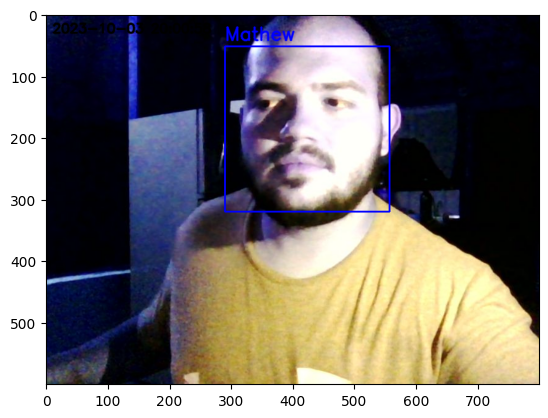

<IPython.core.display.Javascript object>


Lista de asistencia: ['Mathew', 'Mathew', 'Mathew']

Opcion: 1 (Registro de estudiantes)
Opcion: 2 (Registro de profesores)
Opcion: 3 (registro de miselaneos)
Opcion: 4 (registro de aulas)
Opcion: 5 (registro de cursos)
Opcion: 6 (Pasar asistencia de un curso)
Opcion: 7 (Consultas)
Digite 'exit' para salir


KeyboardInterrupt: ignored

In [ ]:
while True:
  print("Opcion: 1 (Registro de estudiantes)")
  print("Opcion: 2 (Registro de profesores)")
  print("Opcion: 3 (registro de miselaneos)")
  print("Opcion: 4 (registro de aulas)")
  print("Opcion: 5 (registro de cursos)")
  print("Opcion: 6 (Pasar asistencia de un curso)")
  print("Opcion: 7 (Consultas)")
  print("Digite 'exit' para salir")
  opc = input()
  match opc:
    case "1":
      print("Modo administrador!")
      print("Dirijase a la seccion de regitro de estudiantes!")
    case "2":
      print("Modo administrador!")
      print("Dirijase a la seccion de regitro profesores!")
    case "3":
      print("Modo administrador!")
      print("Dirijase a la seccion de regitro de miselaneos!")
    case "4":
      registro_aulas()
    case "5":
      registro_cursos()
    case "6":
      match_precentes()
    case "7":
      menu_consultas()
    case "exit":
      print("Gracias :)")
      break
    case _:
      print("Gracias :)")
      break